# Does everything to run entropy and creates slurm files to submit for all diploid likelihoods from bcftools

Goal is 4 chains k=2-7.

In [43]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [44]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [45]:
root = '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/'

In [46]:
cd $root

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall


### Create mgpl & pntest files with associated dir 

In [47]:
ent_dir =os.path.join(root,'entropy_diploidAll')
assert ent_dir

In [48]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll


In [49]:
!gunzip 'final_snps.recode.vcf.gz'

In [50]:
vcf = 'final_snps.recode.vcf'
vcf

'final_snps.recode.vcf'

In [51]:
perl_mpgl = '/data/gpfs/home/tfaske/g/src/perl_scripts/vcf2mpgl_universal.pl'
perl_mean = '/data/gpfs/home/tfaske/g/src/perl_scripts/gl2genest_universal.pl'

In [52]:
!perl $perl_mpgl $vcf

Number of loci: 23425; number of individuals 272


In [53]:
mpgl = 'final_snps.recode.mpgl'

In [54]:
!perl $perl_mean $mpgl mean

### Create ldak files in R

In [55]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
%%R
require(readr)
require(MASS)
require(LEA)
require(ggplot2)
require(ggsci)
require(patchwork)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll')

R[write to console]: Loading required package: LEA



In [57]:
%%R
#create Pop_ID file 

indv<-read.table("../filtering/final_snps.recode.vcf.012.indv",sep="\t")

Sp <- rep(NA,times=nrow(indv))
Ploidy <- rep(NA,times=nrow(indv))
Pop <- rep(NA,times=nrow(indv))
ID <- rep(NA,times=nrow(indv))
All <- rep(NA,times=nrow(indv))
for (i in 1:nrow(indv)){
  SpP <- unlist(strsplit(as.character(indv$V1[i]),"_"))[1]
  Sp[i] <- gsub('\\d','',SpP,perl=TRUE)
  Ploidy[i] <-  gsub('(\\D)','',SpP,perl=TRUE)
  Pop[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[2]
  ID[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[3]
  All[i] <- as.character(indv$V1[i])
}
Pop_ID <- data.frame(Sp=Sp,Ploidy=Ploidy,Pop=Pop,ID=ID,All=All,
                     SpPloidy=paste0(Sp,Ploidy))

print(head(Pop_ID))

write.csv(Pop_ID,"Pop_ID.csv",row.names = FALSE)

  Sp Ploidy Pop ID       All SpPloidy
1 CD      2  IP 10 CD2_IP_10      CD2
2 CD      2  IP 11 CD2_IP_11      CD2
3 CD      2  IP 12 CD2_IP_12      CD2
4 CD      2  IP  1  CD2_IP_1      CD2
5 CD      2  IP  2  CD2_IP_2      CD2
6 CD      2  IP  3  CD2_IP_3      CD2


In [58]:
%%R
g <- read.table("pntest_mean_final_snps.recode.txt", header=F)
dim(g)

[1] 23425   272


In [59]:
%%R
Pop_ID <- read.csv("Pop_ID.csv")
pca_df <- PCA_entropy(t(g))

    PC1     PC2     PC3     PC4     PC5 
0.06536 0.04423 0.03056 0.02775 0.02126 


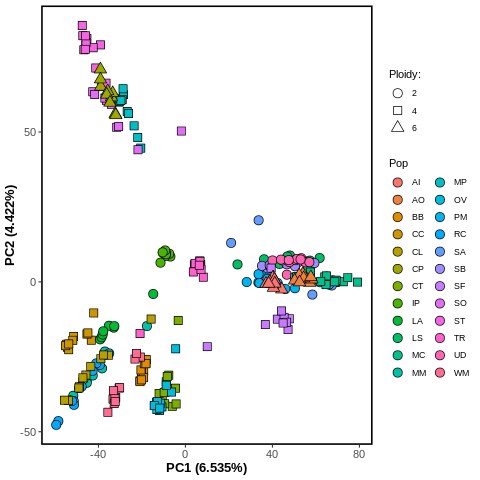

In [60]:
%%R
pca_df <- cbind(pca_df[,1:10],Pop_ID)


ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=Pop,shape=as.character(Ploidy))) + 
  geom_point(colour='black',size = 4)+ #ggtitle("PCA ARTR all") +
  xlab(paste("PC",1," (",0.06535*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",0.04422*100,"%)",sep=""))  +
  #scale_fill_manual(name='Subspecies:',values = col3) +
  scale_shape_manual(name='Ploidy:',values = c(21,22,24)) + 
  guides(fill = guide_legend(override.aes=list(pch=21))) + 
  theme_bw() + 
  theme(#legend.position = 'none',
    axis.text = element_text(size=11), 
    axis.title = element_text(size = 13, colour="black",face = "bold",vjust = 1),
    panel.border = element_rect(size = 1.5, colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())

In [61]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [62]:
%%R
######### create entropy header ####

Pop_ID_list <- Pop_ID$All

Header <- data.frame(dims = NA,Pop_ID_list)

dim(g)

df <- t(Header)
dims <- paste(dim(g)[2],dim(g)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [63]:
!head entropy_header.txt

272 23425                                                                                                                                                                                                                                                                               
CD2_IP_10 CD2_IP_11 CD2_IP_12 CD2_IP_1 CD2_IP_2 CD2_IP_3 CD2_IP_4 CD2_IP_5 CD2_IP_6 CD2_IP_7 CD2_IP_8 CD2_IP_9 CD2_LA_10 CD2_LA_11 CD2_LA_1 CD2_LA_2 CD2_LA_3 CD2_LA_6 CD2_LA_7 CD2_LA_8 CD2_LS_10 CD2_LS_11 CD2_LS_12 CD2_LS_1 CD2_LS_2 CD2_LS_3 CD2_LS_4 CD2_LS_5 CD2_LS_6 CD2_LS_7 CD2_LS_8 CD2_LS_9 CD2_MM_10 CD2_MM_11 CD2_MM_12 CD2_MM_1 CD2_MM_2 CD2_MM_3 CD2_MM_4 CD2_MM_5 CD2_MM_6 CD2_MM_7 CD2_MM_8 CD2_MM_9 CD2_PM_10 CD2_PM_11 CD2_PM_12 CD2_PM_1 CD2_PM_2 CD2_PM_3 CD2_PM_4 CD2_PM_5 CD2_PM_6 CD2_PM_7 CD2_PM_8 CD2_PM_9 CD2_RC_10 CD2_RC_11 CD2_RC_12 CD2_RC_1 CD2_RC_2 CD2_RC_3 CD2_RC_4 CD2_RC_5 CD2_RC_6 CD2_RC_7 CD2_RC_8 CD2_RC_9 CD2_SA_10 CD2_SA_11 CD2_SA_12 CD2_SA_1 CD2_SA_2 CD2_SA_3 CD2_SA_4 CD2_SA_6 CD2_SA_7 CD2_SA

In [64]:
!cat entropy_header.txt final_snps.recode.mpgl > entropy.mpgl

In [65]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll


In [66]:
!mkdir shdir

In [67]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
#account = 'cpu-s1-bionres-0'
#partition = 'cpu-s1-bionres-0'
time = '14-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 16000
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7]
chains = 4

In [68]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [69]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [70]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploi

In [71]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [72]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/home/tfaske/d/milkweed/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [73]:
np.set_printoptions(precision=8) # increases float print option
pd.set_option("precision", 8)

In [74]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll


In [75]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5']

In [76]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [77]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [78]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k3_c2.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt']

In [79]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 11510689.03
Effective number of parameters: 9647303.86
Model DIC: 21157992.88


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 10133819.09
Effective number of parameters: 15469923.88
Model DIC: 25603742.97


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 11511007.72
Effective number of parameters: 9629915.84
Model DIC: 21140923.56


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 10430539.48
Effective number of parameters: 237228564.63
Model DIC: 247659104.11


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 11016501.17
Effective number of parameters: 10933750.49
Model DIC: 21950251.66


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: sa

In [80]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,2.11579929e+07,4
1,7,2.56037430e+07,2
2,2,2.11409236e+07,1
3,6,2.47659104e+08,1
4,3,2.19502517e+07,2


In [81]:
dic_df.to_csv('dic_list.csv')

In [82]:
dic_sum = dic_df.groupby('k').describe().DIC

In [83]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
2,4.0,2.12534977e+07,1.45039658e+05,21140923.56,2.11537256e+07,2.12081830e+07,2.13079551e+07,2.14567011e+07
5,4.0,2.18956498e+07,2.90919473e+05,21577213.04,2.16861661e+07,2.19174881e+07,2.21269719e+07,2.21704100e+07
3,4.0,2.21787502e+07,1.58819341e+05,21950251.66,2.21368678e+07,2.22278332e+07,2.22697156e+07,2.23090829e+07
4,4.0,2.27178447e+07,5.18088260e+05,21989430.24,2.25267769e+07,2.28895059e+07,2.30805737e+07,2.31029366e+07
7,4.0,2.51297817e+07,7.44636593e+05,24063178.57,2.48974541e+07,2.53896445e+07,2.56219720e+07,2.56766593e+07
6,4.0,1.81264369e+08,7.57427634e+07,101312680.22,1.24205001e+08,1.88042846e+08,2.45102214e+08,2.47659104e+08


In [84]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [85]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 272, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 272, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 272, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 272, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 272, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

In [86]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 272, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 272, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 272, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 272, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 272, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

### make slurm script to make gprob file

    use all k and chains to make gprob

In [87]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll


In [88]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,5,6,7]

In [89]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [90]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [91]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_gprob_k5.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_gprob_k6.sh',
 '/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/entropy_diploidAll/shdir/run_gprob_k7.sh']

In [92]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [93]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

In [94]:
hdf5_files = []
for k in num_k:
    f = '../entropy_k' + str(k) + '_c*hdf5'
    hdf5_files.append(f)
hdf5_files

['../entropy_k2_c*hdf5',
 '../entropy_k3_c*hdf5',
 '../entropy_k4_c*hdf5',
 '../entropy_k5_c*hdf5',
 '../entropy_k6_c*hdf5',
 '../entropy_k7_c*hdf5']

In [95]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c*hdf5 ../entropy_k3_c*hdf5 ../entropy_k4_c*hdf5 ../entropy_k5_c*hdf5 ../entropy_k6_c*hdf5 ../entropy_k7_c*hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [96]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [97]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [98]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 
    cd /data/gpfs/home/tfaske/d/sagebrush/SNPcall/AT2/entropy
    source activate entropy
    sbatch run_gprob.sh

In [ ]:
#gprobs
#!$estpost *k2*.hdf5 -p gprob -s 0 -o gprob2.txt

#!$estpost *k3*.hdf5 -p gprob -s 0 -o gprob3.txt

#!$estpost *k4*.hdf5 -p gprob -s 0 -o gprob4.txt

#!$estpost *k5*.hdf5 -p gprob -s 0 -o gprob5.txt